In [1]:
!nvidia-smi

Fri Dec 17 10:05:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3080    On   | 00000000:2B:00.0  On |                  N/A |
| 32%   33C    P8    22W / 340W |    401MiB / 10009MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import yaml
import glob
import matplotlib.pyplot as plt
import os

from utils.plots import plot_results
from IPython.display import Image
from IPython.core.magic import register_line_cell_magic

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
%matplotlib inline

Setup complete. Using torch 1.8.1+cu111 _CudaDeviceProperties(name='GeForce RTX 3080', major=8, minor=6, total_memory=10009MB, multi_processor_count=68)


### Augment the dataset

Step 1: Resize to desired size<br>
Step 2: Generate "n" augmented images per original image.

In [3]:
!python augmentation_pipeline.py --dir chess_dataset/ --size 416 --n 3

2021-12-17::10:02:57 | Resize Dataset  | Resizing dataset...
2021-12-17::10:02:57 | Resize Dataset  | Created augmented_dataset folder to store images
2021-12-17::10:02:57 | Resize Dataset  | Copying files from original dataset folder...
2021-12-17::10:02:57 | Resize Dataset  | All files successfully copied.
2021-12-17::10:02:57 | Resize Dataset  | Grabbing image paths...
2021-12-17::10:02:57 | Resize Dataset  | Resizing 329 images...
2021-12-17::10:02:57 | Resize Dataset  | Assigning 22 images to each process
2021-12-17::10:02:57 | Resize Dataset  | Launching 15 processes...
2021-12-17::10:02:57 | Resize Dataset  | Processing...
2021-12-17::10:02:57 | Resize Dataset  | starting process 0
2021-12-17::10:02:57 | Resize Dataset  | starting process 2
2021-12-17::10:02:57 | Resize Dataset  | starting process 1
2021-12-17::10:02:57 | Resize Dataset  | starting process 3
2021-12-17::10:02:57 | Resize Dataset  | starting process 4
2021-12-17::10:02:57 | Resize Dataset  | starting process 5
20

In [4]:
%cd augmented_dataset/
!rm data.yaml
filename = "data.yaml"

with open(filename, "w") as f:
    f.write(f"train: {os.getcwd()}/train/images\n")
    f.write(f"val: {os.getcwd()}/valid/images\n")
    f.write("\n")
    f.write("nc: 12\n")
    f.write("names: ['black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']\n")
    f.close()
%cd ..

/home/rohan/object_detection/e2e_yolov5/augmented_dataset
/home/rohan/object_detection/e2e_yolov5


In [5]:
%cat augmented_dataset/data.yaml

train: /home/rohan/object_detection/e2e_yolov5/augmented_dataset/train/images
val: /home/rohan/object_detection/e2e_yolov5/augmented_dataset/valid/images

nc: 12
names: ['black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']


In [6]:
with open("augmented_dataset/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

print(num_classes)

12


In [7]:
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [8]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [9]:
!python train.py --img 416 --batch 8 --epochs 100 --data augmented_dataset/data.yaml --cfg models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_chess  --cache

train: weights=yolov5s.pt, cfg=models/custom_yolov5s.yaml, data=augmented_dataset/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=8, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=yolov5s_chess, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2021-12-4 torch 1.8.1+cu111 CUDA:0 (GeForce RTX 3080, 10010MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gam

      3/99      1.1G   0.07038   0.06441   0.06057       131       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.177      0.429      0.184      0.067

     Epoch   gpu_mem       box       obj       cls    labels  img_size
      4/99      1.1G   0.06597   0.05847   0.05966       146       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386     0.0589      0.634       0.16     0.0554

     Epoch   gpu_mem       box       obj       cls    labels  img_size
      5/99      1.1G   0.06289   0.05578   0.05849        65       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.519      0.274      0.285      0.116

     Epoch   gpu_mem       box       obj       cls    labels  img_size
      6/99      1.1G   0.06029   0.05


     Epoch   gpu_mem       box       obj       cls    labels  img_size
     29/99      1.1G   0.03565   0.04022    0.0207        65       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.857      0.926      0.918      0.622

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     30/99      1.1G   0.03459   0.04052   0.01995       158       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.926      0.895      0.936      0.641

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     31/99      1.1G   0.03561   0.04141   0.01986        90       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.913      0.925       0.95      0.683

     Epoch   gpu_mem       box      

               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.978       0.99      0.985      0.759

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     55/99      1.1G   0.02965   0.03633   0.01046       100       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.979      0.989      0.988      0.724

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     56/99      1.1G    0.0276   0.03496    0.0102       117       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.966      0.991      0.985      0.767

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     57/99      1.1G   0.02679   0.03517  0.009987       218       416: 100%|███
               Class     Images     L


     Epoch   gpu_mem       box       obj       cls    labels  img_size
     80/99      1.1G    0.0234    0.0324  0.007674       114       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.979       0.99      0.985       0.77

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     81/99      1.1G   0.02336   0.03191  0.007625        53       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.983      0.992      0.986      0.787

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     82/99      1.1G   0.02344   0.03266  0.007649       152       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.981      0.992      0.986      0.784

     Epoch   gpu_mem       box      

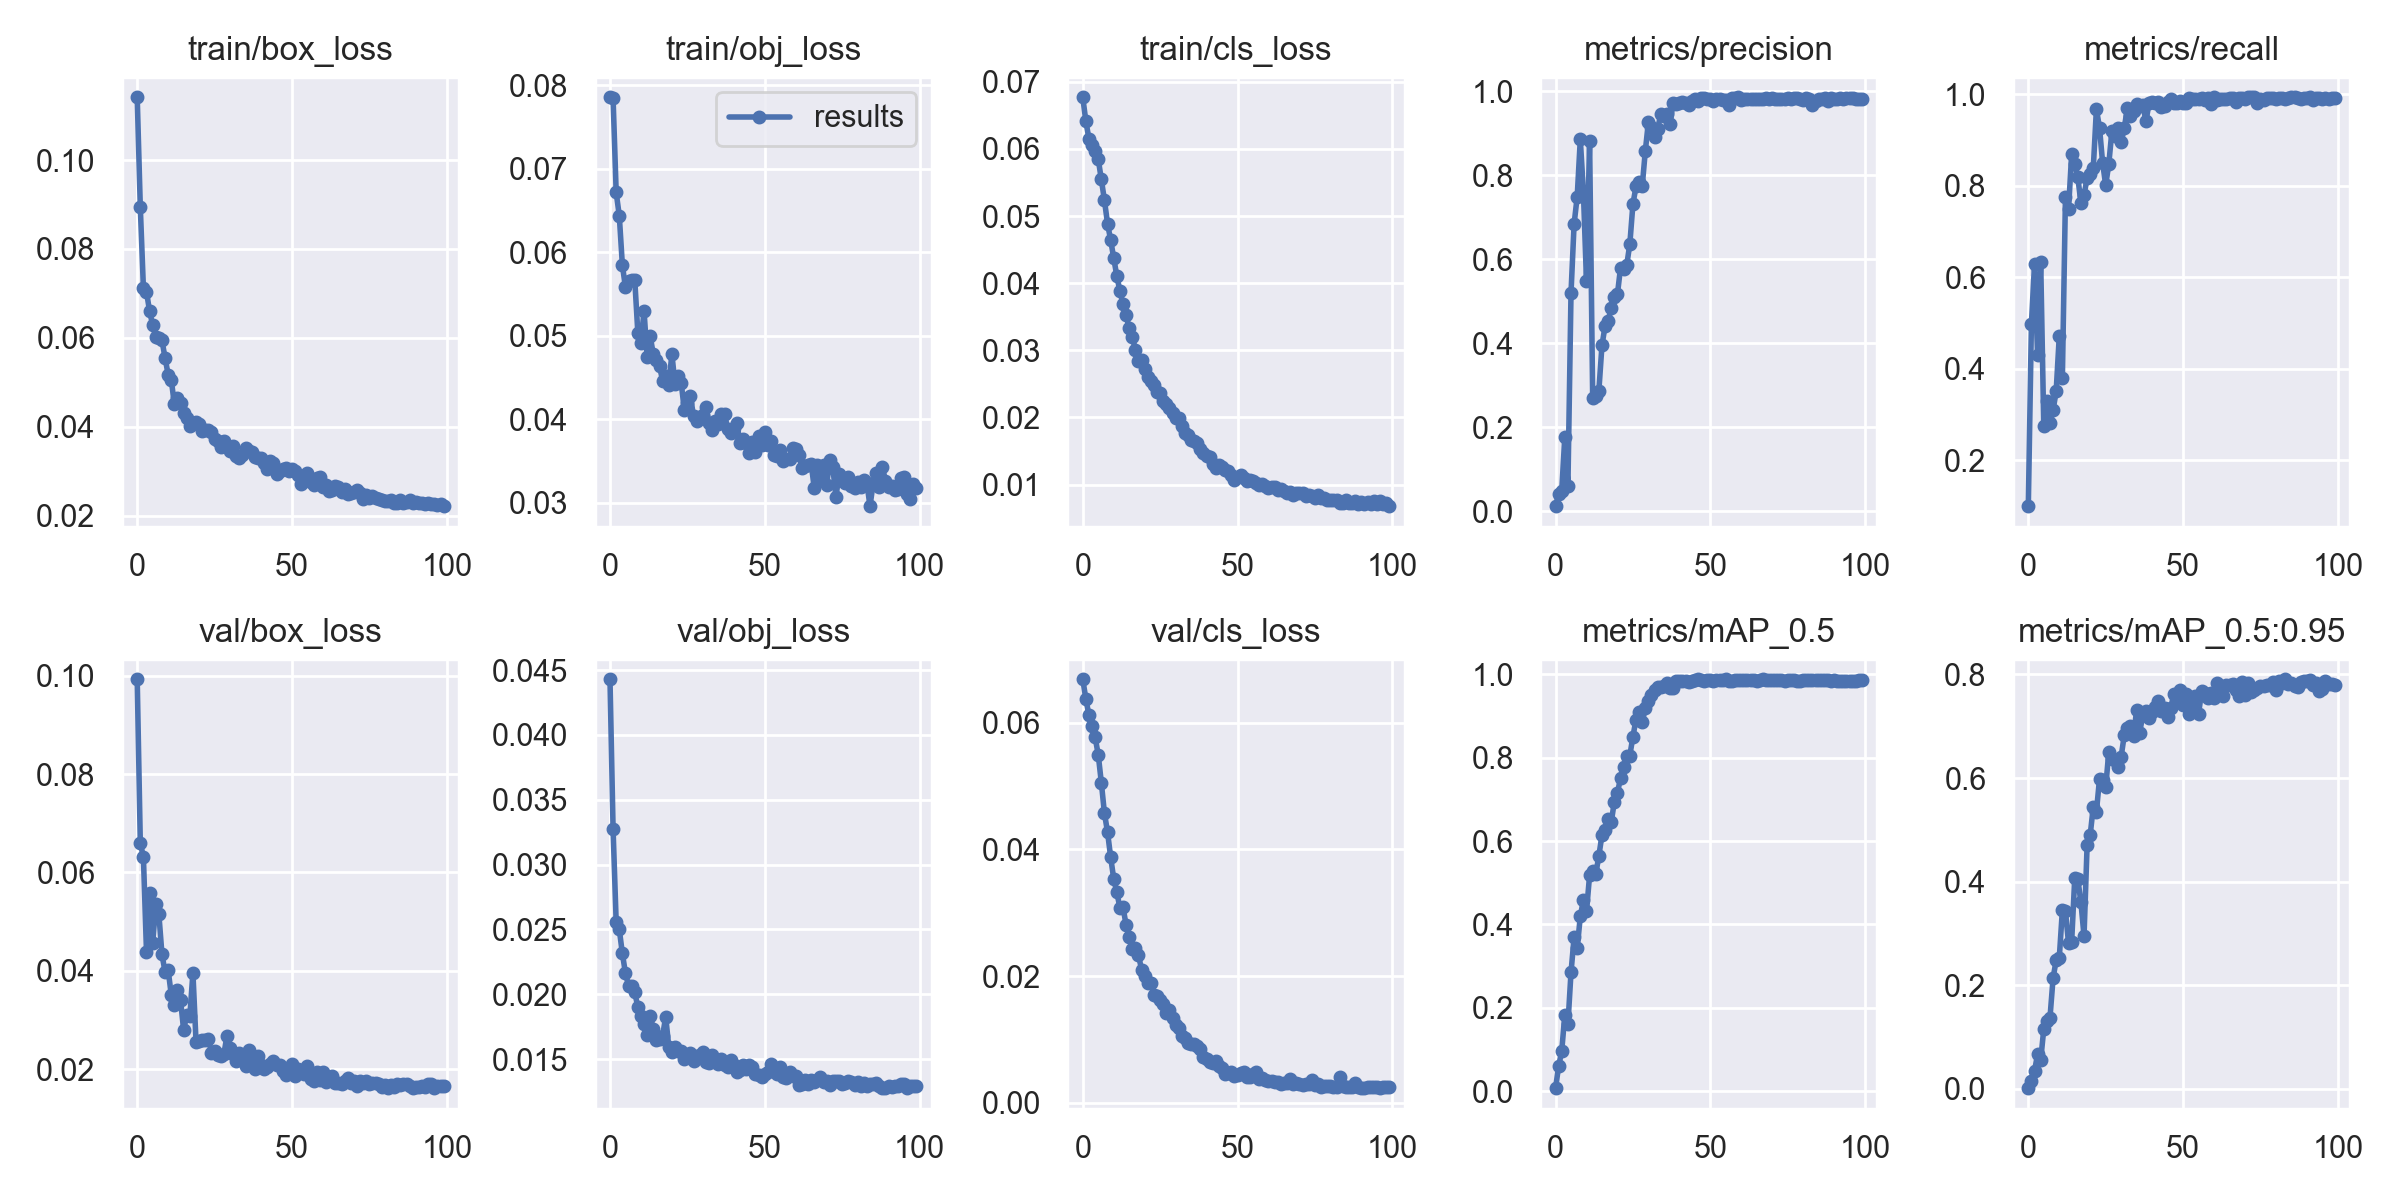

In [10]:
Image(filename = "/home/rohan/object_detection/e2e_yolov5/runs/train/yolov5s_chess/results.png")

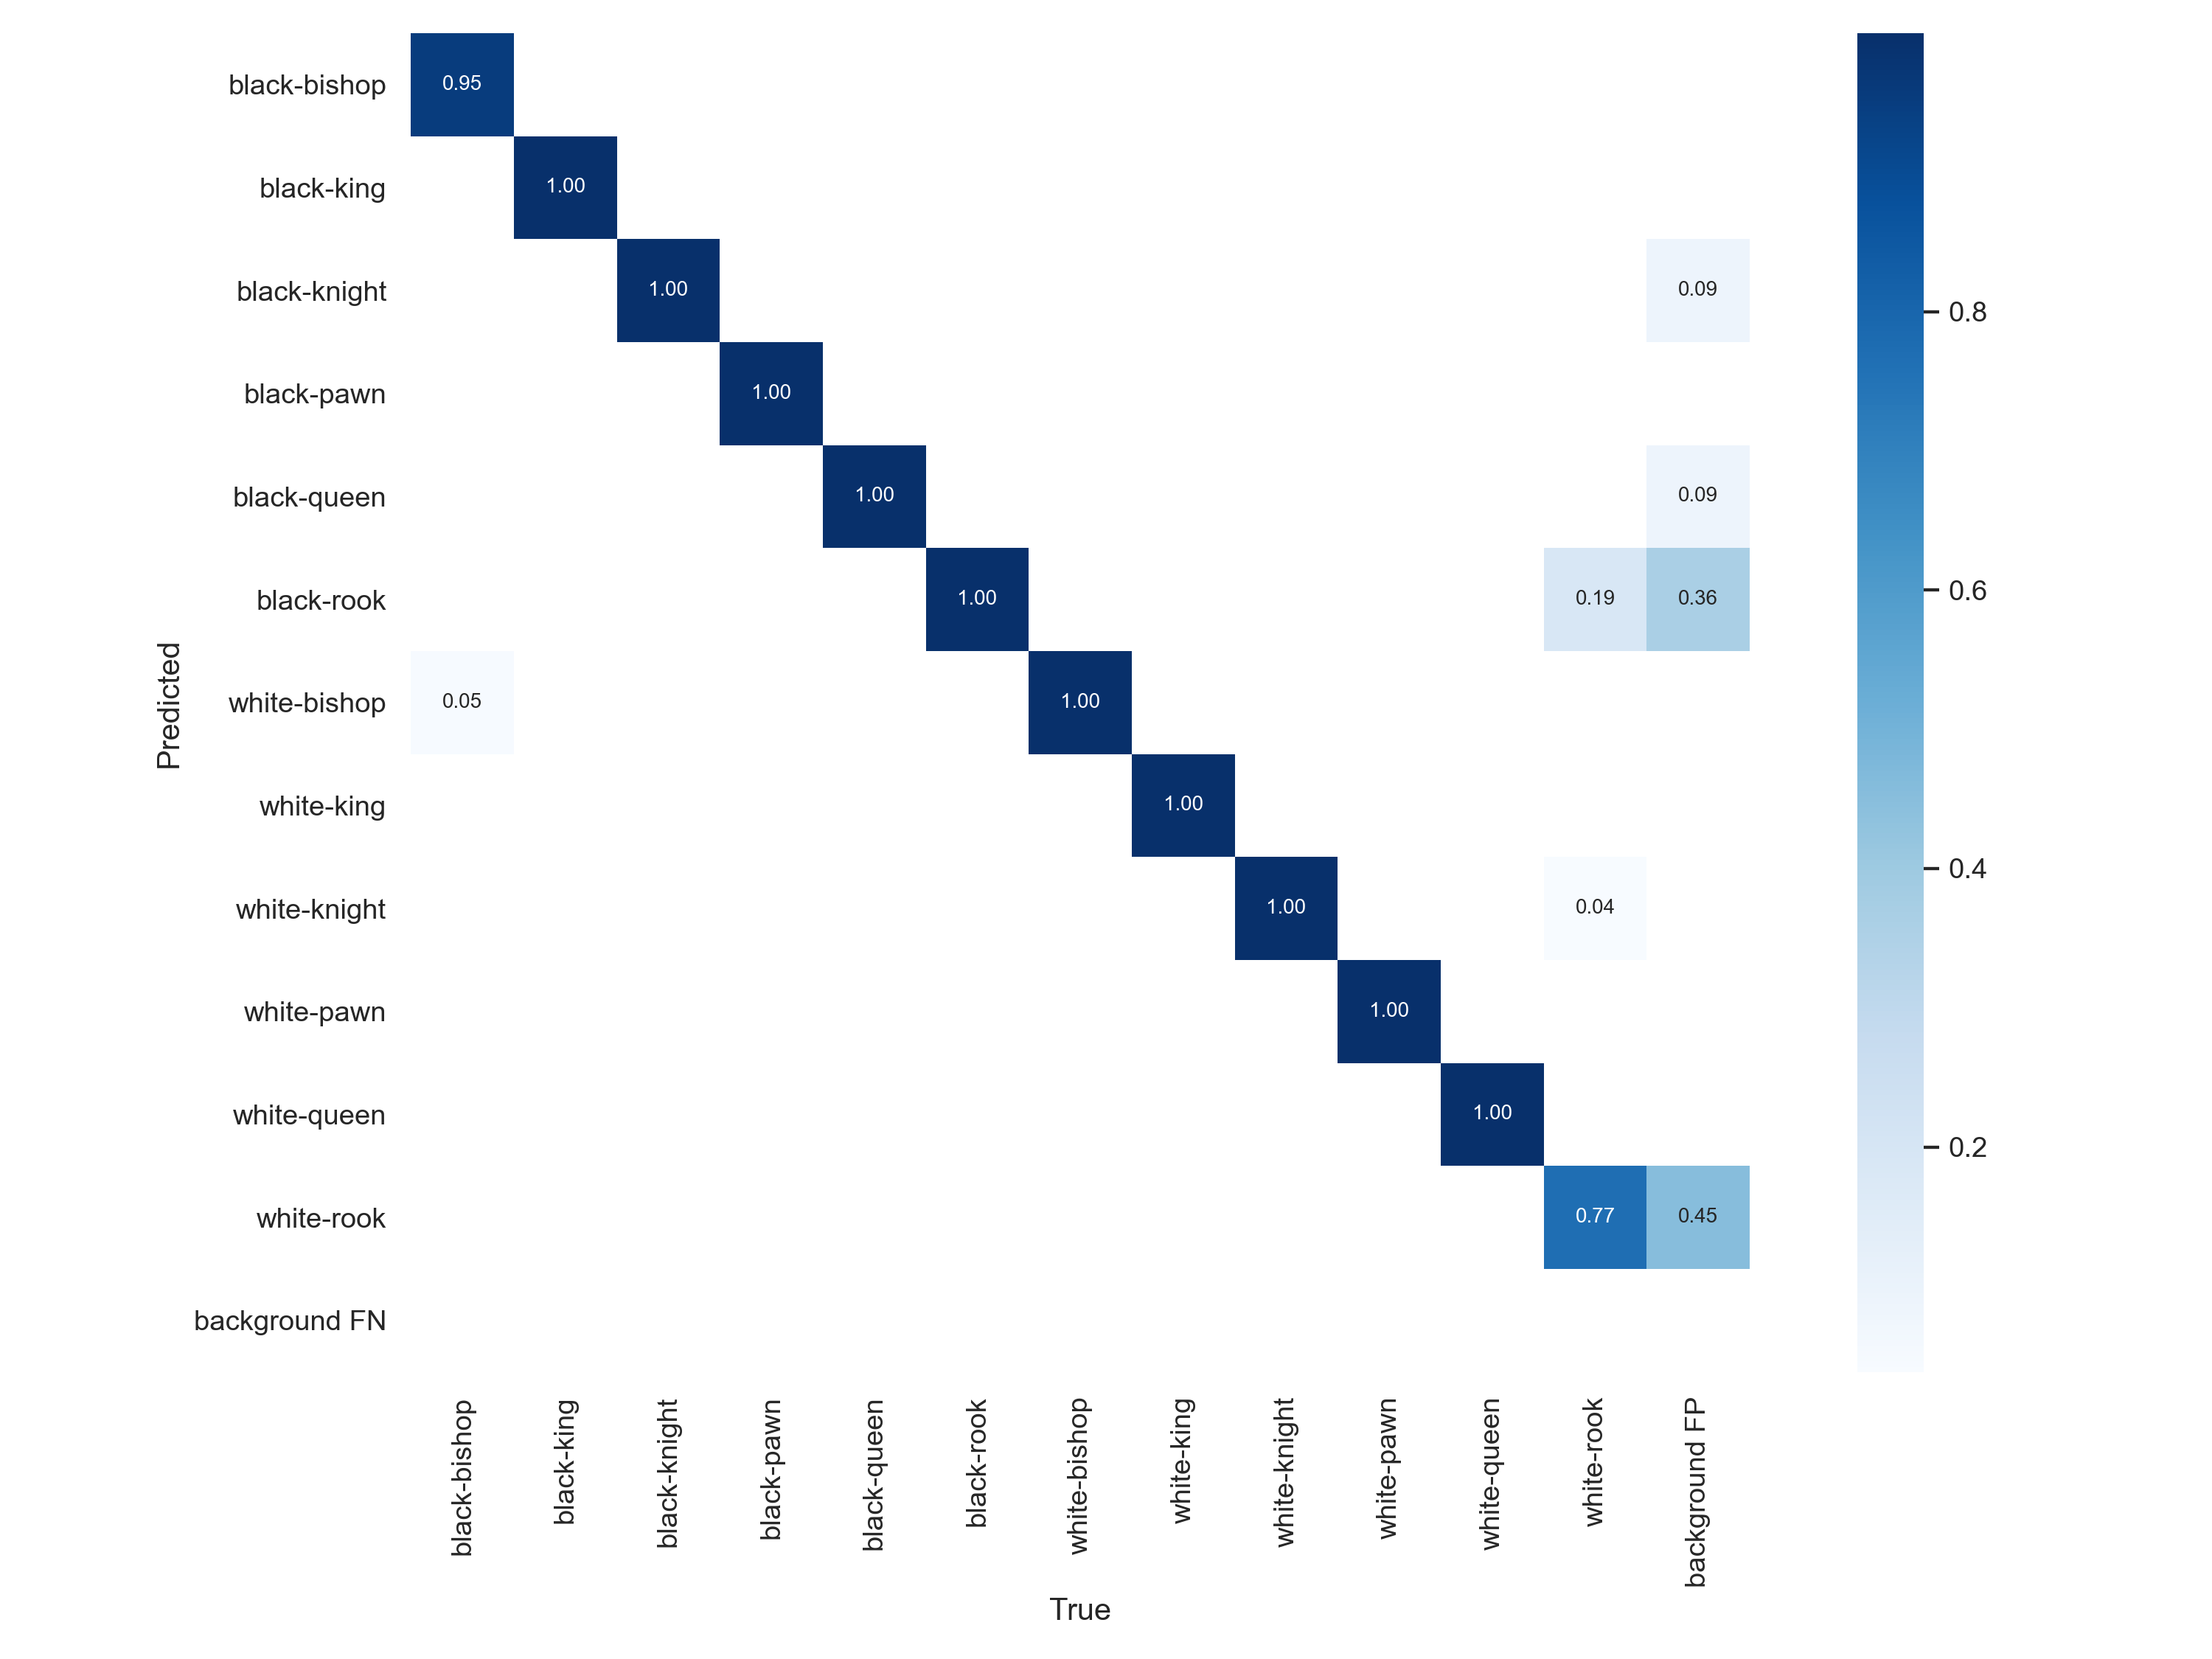

In [11]:
Image(filename = "/home/rohan/object_detection/e2e_yolov5/runs/train/yolov5s_chess/confusion_matrix.png")